In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms
import pandas as pd
from PIL import Image
from sklearn.metrics import f1_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from timm import create_model
from sklearn.metrics import multilabel_confusion_matrix

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# === Gerekli Kütüphaneler ===
import os
import numpy as np
import pandas as pd
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

from sklearn.metrics import f1_score

from timm import create_model

# === Sabitler ===
AU_LIST = ['AU1', 'AU2', 'AU3', 'AU4', 'AU6', 'AU9', 'AU12', 'AU20']

# === Dataset Sınıfı ===
class AU_Dataset(Dataset):
    def __init__(self, csv_file, image_dir, transform=None):
        self.data = pd.read_csv(csv_file)
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        image_path = os.path.join(self.image_dir, row['fname'])
        image = Image.open(image_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        labels = torch.FloatTensor(row[AU_LIST].values.astype(np.float32))
        return image, labels

# === Model Sınıfı ===
class AUModel(nn.Module):
    def __init__(self, num_aus, dropout_rate=0.5):
        super(AUModel, self).__init__()
        self.base_model = create_model('deit_small_patch16_224', pretrained=True)
        in_features = self.base_model.head.in_features
        self.base_model.head = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(in_features, num_aus)
        )

    def forward(self, x):
        return self.base_model(x)

# === Threshold Optimizasyonu ===
def optimize_thresholds(preds, targets):
    thresholds = []
    for i in range(preds.shape[1]):
        best_f1 = 0
        best_thresh = 0.5
        for t in np.arange(0.1, 0.9, 0.01):
            f1 = f1_score(targets[:, i], (preds[:, i] > t).astype(int))
            if f1 > best_f1:
                best_f1 = f1
                best_thresh = t
        thresholds.append(best_thresh)
    return np.array(thresholds)

# === Eğitim Fonksiyonu ===
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    losses = []
    all_preds = []
    all_targets = []

    for imgs, labels in loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        all_preds.append(torch.sigmoid(outputs).detach().cpu().numpy())
        all_targets.append(labels.cpu().numpy())

    preds = np.concatenate(all_preds)
    targets = np.concatenate(all_targets)
    thresholds = np.full(preds.shape[1], 0.5)
    f1 = f1_score(targets, preds > thresholds, average='macro')

    return np.mean(losses), f1

# === Değerlendirme Fonksiyonu ===
def evaluate(model, loader, criterion, device):
    model.eval()
    losses = []
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)

            losses.append(loss.item())
            all_preds.append(torch.sigmoid(outputs).cpu().numpy())
            all_targets.append(labels.cpu().numpy())

    preds = np.concatenate(all_preds)
    targets = np.concatenate(all_targets)
    thresholds = np.full(preds.shape[1], 0.5)
    f1 = f1_score(targets, preds > thresholds, average='macro')

    return np.mean(losses), f1, preds, targets

# === Ana Eğitim Döngüsü ===
def run_training(train_csvs, test_csvs, image_dir, num_epochs=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.5]*3, [0.5]*3)
    ])

    all_preds = []
    all_targets = []

    for fold in range(len(train_csvs)):
        print(f"===== Fold {fold + 1} =====")

        train_set = AU_Dataset(train_csvs[fold], image_dir, transform)
        test_set = AU_Dataset(test_csvs[fold], image_dir, transform)

        train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
        test_loader = DataLoader(test_set, batch_size=32, shuffle=False)

        model = AUModel(num_aus=len(AU_LIST)).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

        # AU2 için ağırlığı artır
        pos_weights = torch.tensor([1.0 if au != 'AU2' else 4.0 for au in AU_LIST]).to(device)
        criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weights)

        best_f1 = 0
        patience = 3
        counter = 0

        for epoch in range(num_epochs):
            train_loss, train_f1 = train_one_epoch(model, train_loader, optimizer, criterion, device)
            test_loss, test_f1, test_preds, test_targets = evaluate(model, test_loader, criterion, device)

            print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | Train F1: {train_f1:.4f} | Test F1: {test_f1:.4f}")

            if test_f1 > best_f1:
                best_f1 = test_f1
                counter = 0
                torch.save(model.state_dict(), f"best_model_fold{fold}.pt")
            else:
                counter += 1
                if counter >= patience:
                    print(f"Early stopping at epoch {epoch+1}")
                    break

        model.load_state_dict(torch.load(f"best_model_fold{fold}.pt"))
        _, _, test_preds, test_targets = evaluate(model, test_loader, criterion, device)

        best_thresholds = optimize_thresholds(test_preds, test_targets)
        final_preds = (test_preds > best_thresholds).astype(int)

        pd.DataFrame(final_preds, columns=AU_LIST).to_csv(f"preds_fold{fold}.csv", index=False)
        pd.DataFrame(test_targets, columns=AU_LIST).to_csv(f"targets_fold{fold}.csv", index=False)
        pd.DataFrame(best_thresholds, columns=['Thresholds']).to_csv(f"thresholds_fold{fold}.csv", index=False)

        all_preds.append(final_preds)
        all_targets.append(test_targets)

    all_preds = np.concatenate(all_preds)
    all_targets = np.concatenate(all_targets)
    pd.DataFrame(all_preds, columns=AU_LIST).to_csv('all_preds.csv', index=False)
    pd.DataFrame(all_targets, columns=AU_LIST).to_csv('all_targets.csv', index=False)

    print("\n=== Eğitim Tamamlandı! ===")

# === Ana Çağrı ===
train_csv_files = [f'drive/My Drive/TIF/train_new/TIF_AUG_AU_SI_ver1_fold_{i}.csv' for i in range(3)]
test_csv_files = [f'drive/My Drive/TIF/val_new/TIF_AUG_AU_SI_ver1_fold_{i}.csv' for i in range(3)]
image_dir = 'drive/My Drive/TIF/CroppedFromPhotos/TIF_DB_Augmented'

run_training(train_csv_files, test_csv_files, image_dir)


===== Fold 1 =====


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/88.2M [00:00<?, ?B/s]

Epoch 1/10 | Train Loss: 0.6510 | Train F1: 0.4810 | Test F1: 0.5582
Epoch 2/10 | Train Loss: 0.4442 | Train F1: 0.7511 | Test F1: 0.5688
Epoch 3/10 | Train Loss: 0.2391 | Train F1: 0.8848 | Test F1: 0.6195
Epoch 4/10 | Train Loss: 0.1177 | Train F1: 0.9608 | Test F1: 0.6562
Epoch 5/10 | Train Loss: 0.0679 | Train F1: 0.9839 | Test F1: 0.5858
Epoch 6/10 | Train Loss: 0.0384 | Train F1: 0.9962 | Test F1: 0.6304
Epoch 7/10 | Train Loss: 0.0244 | Train F1: 0.9994 | Test F1: 0.6221
Early stopping at epoch 7
===== Fold 2 =====
Epoch 1/10 | Train Loss: 0.6407 | Train F1: 0.5381 | Test F1: 0.5354
Epoch 2/10 | Train Loss: 0.4188 | Train F1: 0.7509 | Test F1: 0.5422
Epoch 3/10 | Train Loss: 0.2209 | Train F1: 0.8951 | Test F1: 0.6461
Epoch 4/10 | Train Loss: 0.1441 | Train F1: 0.9412 | Test F1: 0.5998
Epoch 5/10 | Train Loss: 0.0661 | Train F1: 0.9895 | Test F1: 0.5848
Epoch 6/10 | Train Loss: 0.0402 | Train F1: 0.9967 | Test F1: 0.6131
Early stopping at epoch 6
===== Fold 3 =====
Epoch 1/10 | 

In [ ]:
model = AUModel(num_aus=len(AU_LIST))
model.load_state_dict(torch.load("best_model_fold0.pt", map_location='cpu'))
model.eval()


AUModel(
  (base_model): VisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
      (norm): Identity()
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (patch_drop): Identity()
    (norm_pre): Identity()
    (blocks): Sequential(
      (0): Block(
        (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=384, out_features=1152, bias=True)
          (q_norm): Identity()
          (k_norm): Identity()
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=384, out_features=384, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (ls1): Identity()
        (drop_path1): Identity()
        (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=384, out_features=1536, bias=True)
          (act): GELU(approximate='none')

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# AU listesi (etiketler)
AU_LIST = ['AU1', 'AU2', 'AU3', 'AU4', 'AU6', 'AU9', 'AU12', 'AU20']

# CSV dosyalarını oku
preds_df = pd.read_csv('all_preds.csv')
targets_df = pd.read_csv('all_targets.csv')

# Her AU için confusion matrix çiz
for au in AU_LIST:
    preds = preds_df[au]
    targets = targets_df[au]

    cm = confusion_matrix(targets, preds)

    plt.figure(figsize=(4, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Negatif', 'Pozitif'],
                yticklabels=['Negatif', 'Pozitif'])
    plt.title(f'Confusion Matrix - {au}')
    plt.xlabel('Tahmin')
    plt.ylabel('Gerçek')
    plt.tight_layout()
    plt.savefig(f'confusion_matrix_{au}.png')
    plt.close()


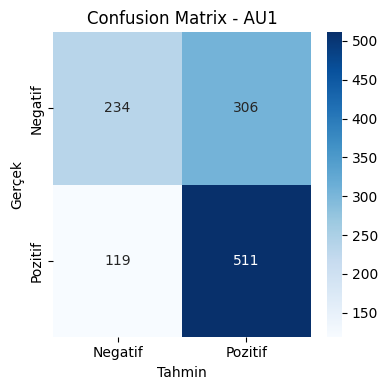

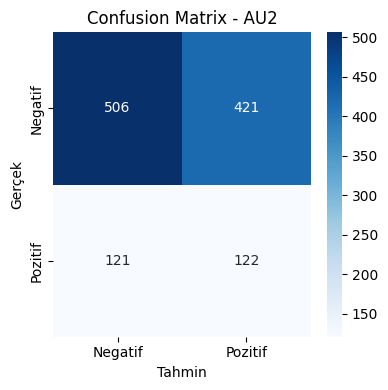

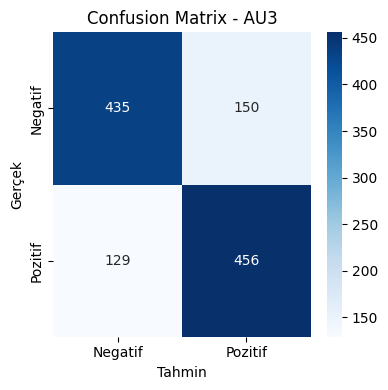

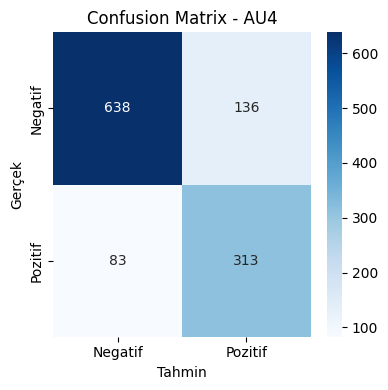

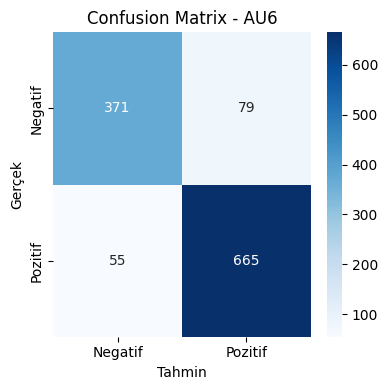

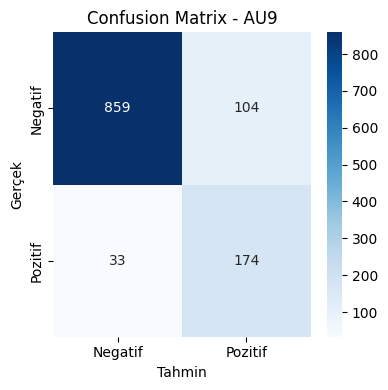

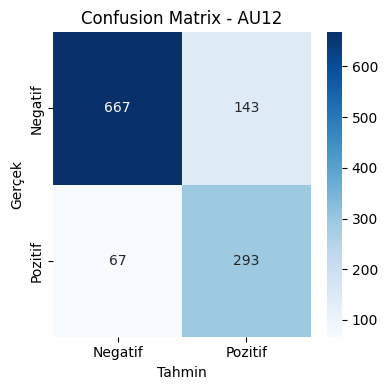

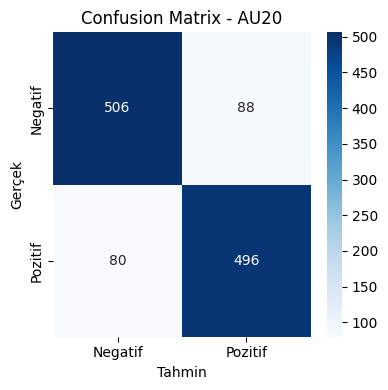

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# AU listesi
AU_LIST = ['AU1', 'AU2', 'AU3', 'AU4', 'AU6', 'AU9', 'AU12', 'AU20']

# CSV dosyalarını oku
preds_df = pd.read_csv('all_preds.csv')
targets_df = pd.read_csv('all_targets.csv')

# Her AU için confusion matrix çiz
for au in AU_LIST:
    preds = preds_df[au]
    targets = targets_df[au]

    cm = confusion_matrix(targets, preds)

    plt.figure(figsize=(4, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Negatif', 'Pozitif'],
                yticklabels=['Negatif', 'Pozitif'])
    plt.title(f'Confusion Matrix - {au}')
    plt.xlabel('Tahmin')
    plt.ylabel('Gerçek')
    plt.tight_layout()
    plt.show()  # Görsel olarak direkt göster


In [ ]:
import pandas as pd
from sklearn.metrics import confusion_matrix

# AU listesi
AU_LIST = ['AU1', 'AU2', 'AU3', 'AU4', 'AU6', 'AU9', 'AU12', 'AU20']

# Verileri oku
preds_df = pd.read_csv('all_preds.csv')
targets_df = pd.read_csv('all_targets.csv')

# Sonuçları tutacak liste
results = []

# Her AU için metrikleri hesapla
for au in AU_LIST:
    preds = preds_df[au]
    targets = targets_df[au]

    tn, fp, fn, tp = confusion_matrix(targets, preds).ravel()
    recall = 100 * tp / (tp + fn) if (tp + fn) > 0 else 0.0

    results.append({
        'AU': au,
        'TP': tp,
        'TN': tn,
        'Recall (%)': round(recall, 2)
    })

# Sonuçları DataFrame olarak oluştur
results_df = pd.DataFrame(results)

# Ekrana yazdır
print(results_df)

# CSV'ye kaydet
results_df.to_csv('au_metrics_summary.csv', index=False)


     AU   TP   TN  Recall (%)
0   AU1  511  234       81.11
1   AU2  122  506       50.21
2   AU3  456  435       77.95
3   AU4  313  638       79.04
4   AU6  665  371       92.36
5   AU9  174  859       84.06
6  AU12  293  667       81.39
7  AU20  496  506       86.11


In [ ]:
import pandas as pd
from sklearn.metrics import f1_score

# Tahmin ve gerçek etiketleri oku
preds_df = pd.read_csv('all_preds.csv')
targets_df = pd.read_csv('all_targets.csv')

# NumPy array'e çevir
preds = preds_df.values
targets = targets_df.values

# Makro F1-score hesapla (AU'lar üzerinde ortalama)
macro_f1 = f1_score(targets, preds, average='macro')
print(f"Makro F1-score: {round(macro_f1 * 100, 2)}%")


Makro F1-score: 71.76%
